In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

Membaca data dari dataset

In [4]:
df_train = pd.read_csv("../content/Corona_NLP_train.csv",encoding='latin1')
df_test = pd.read_csv("../content/Corona_NLP_test.csv",encoding='latin1')

Mengecek data 7 baris awal

In [5]:
df_train.head(7)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


Mengecek data 7 baris awal

In [6]:
df_test.head(7)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


In [7]:
df_train.shape 


(41157, 6)

In [8]:
df_test.shape

(3798, 6)

Mempersiapkan data sentimen berdasarkan klasifikasinya

In [9]:
y = df_train["Sentiment"].map({"Negative":0,
                               "Positive": 1,
                               "Neutral": 2,
                               "Extremely Positive": 3,
                               "Extremely Negative": 4
                               })

y_test = df_test["Sentiment"].map({"Negative":0,
                                   "Positive": 1,
                                   "Neutral": 2,
                                   "Extremely Positive": 3,
                                   "Extremely Negative": 4
                                                })

In [10]:
# get the number of classes
n_classes = df_train["Sentiment"].nunique()
n_classes

5

Text Vectorization

In [11]:
# extract text data from dataframe 
X = df_train['OriginalTweet'].to_numpy()
X_test = df_test['OriginalTweet'].to_numpy()

In [12]:
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation", 
                                    output_sequence_length=15)

In [13]:
text_vectorizer.adapt(X)

In [14]:
text_vectorizer(["Computer vision and deep learning"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4031, 8344,    4, 1661, 2049,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [15]:
words = text_vectorizer.get_vocabulary()

In [16]:
words[:10] # check data

['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'coronavirus', 'covid19']

In [17]:
# turns positive integers (indexes) into dense vectors of fixed size
embedding = Embedding(input_dim=10000, output_dim=128, input_length=15, name = 'embeding_1')
embedding

In [18]:
# example
sample_embed = embedding(text_vectorizer(["Computer vision and deep learning"]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01589862,  0.0168657 , -0.01446525, ...,  0.00176603,
         -0.00992408,  0.03749085],
        [-0.03789983,  0.02912115,  0.00073105, ..., -0.00833086,
         -0.00055548, -0.02665188],
        [ 0.01528556,  0.01339154, -0.02836205, ...,  0.04887846,
          0.04298503, -0.02774719],
        ...,
        [ 0.00917789,  0.01282764, -0.01221674, ..., -0.01685131,
          0.0495932 , -0.02457782],
        [ 0.00917789,  0.01282764, -0.01221674, ..., -0.01685131,
          0.0495932 , -0.02457782],
        [ 0.00917789,  0.01282764, -0.01221674, ..., -0.01685131,
          0.0495932 , -0.02457782]]], dtype=float32)>

Train models

In [19]:
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [20]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()

In [21]:
def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    """ GENERAL FUNCTION FOR RUNNING NEURAL NETWORK MODELS"""
    
    # create model
    model = tf.keras.Model(inputs, outputs, name=name)
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=["accuracy"])
    # check model
    model.summary()
    print()
    # train model
    print("...training model...")
    model_history = model.fit(X, 
                              y, 
                              epochs=epochs, 
                              validation_data=(X_test, y_test),
                              verbose=True)
    print()
    # check on test data
    print("...evaluating model...")
    model.evaluate(X_test, y_test)
    print()
    
    # check shape
    print("y_test.shape = ", y_test.shape)
    print()
    
    # get the probabilities
    y_prob = model.predict(X_test)
    # get the classes
    y_hat = y_prob.argmax(axis=-1) 
    # see the test labels
    print("y_test =\n", y_test)
    print()
    # check results
    res = calculate_results(y_test, y_hat)
    res = pd.DataFrame([res])
    res.insert(0, "model", NN_name)
    # visualize NN history
    plot_NN_history(model_history, suptitle)
    return model, res

LSTM

In [22]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1,329,733
Trainable params: 1,329,733
Non-trainable params: 0
______________________________________________

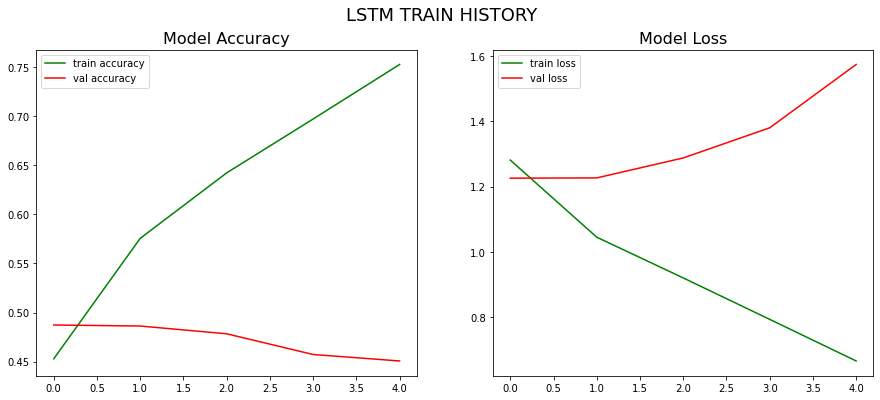

,model,accuracy,precision,recall,f1
0,LSTM,45.076356,0.453867,0.450764,0.448806


In [23]:
# run our model
model, res = run_model(inputs, outputs, "model_LSTM", 5, "LSTM", "LSTM TRAIN HISTORY")
res # print the accuracy metrics results